In [1]:
#Importing all the required libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score,recall_score\
,f1_score,classification_report,confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression

In [2]:
#Downloading the dataset, creating dataframe
df = pd.read_excel("env_data.xlsx")

#Remove temperature readings at 260cm
df = df.drop(['Mean 260 (°C)'], axis=1)
df

,Mean 060 (°C),54: TC_Smoke (°C),187: CO_room (ppm),labels
0,9.643126,8.613041,695.565623,safe
1,9.638108,8.614577,693.682888,safe
2,9.629587,8.612079,686.368593,safe
3,9.633649,8.603408,690.206866,safe
4,10.224093,8.608649,704.980179,safe
...,...,...,...,...
65885,762.177943,35.854659,561.929191,danger
65886,762.140202,35.787602,561.493785,danger
65887,762.108967,35.693921,579.051064,danger
65888,762.075566,35.595093,576.439508,danger


In [3]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df['labels'] = df['labels'].map(target_mapping)

# Separating data & target information
X = df.iloc[:, :3]
y = df.iloc [:, -1]

print('Number of safe, caution and danger respectively in target:', np.bincount(y))

Number of safe, caution and danger respectively in target: [ 9532 11924 44434]


In [4]:
#Split dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True, stratify=y)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({2: 31104, 1: 8347, 0: 6672})
Testing target statistics: Counter({2: 13330, 1: 3577, 0: 2860})


In [5]:
#Balance the train split
over_sampler = RandomOverSampler(random_state=1)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 31104, 0: 31104, 2: 31104})
Testing target statistics: Counter({2: 13330, 1: 3577, 0: 2860})


In [6]:
#ccreate pipeline for LR
pipe_logreg = make_pipeline(StandardScaler(),
                             LogisticRegression(random_state=1, C=100, penalty= 'l1', solver='liblinear', max_iter=2500, class_weight="balanced"),
                            )

In [7]:
# Cross validation (cv)
k_fold = StratifiedKFold(n_splits=10)

In [8]:
#create a function that trains the model and returns result using stratified 10 folds cv
def train_model(X_res, y_res, classifier_pipeline):

    training_result = []
    validation_result=[]

    i=1
    for  train_index, val_index in k_fold.split(X_res, y_res):
        X_res_fold, y_res_fold = X_res.values[train_index,:], y_res.values[train_index]
        X_val_fold, y_val_fold = X_res.values[val_index,:], y_res.values[val_index]

        #for each fold: training a logistic regression model using the 
        #pipeline of steps
        classifier_pipeline.fit(X_res_fold, y_res_fold)

        #get predictions and predictions probabilities
        y_res_predictions=classifier_pipeline.predict(X_res_fold)
        y_val_predictions = classifier_pipeline.predict(X_val_fold)

        y_res_probabilities= classifier_pipeline.predict_proba(X_res_fold)
        y_val_probabilities= classifier_pipeline.predict_proba(X_val_fold)

        #print auc score 
        train_auc = roc_auc_score(y_res_fold,y_res_probabilities, multi_class="ovr")
        valid_auc = roc_auc_score(y_val_fold, y_val_probabilities, multi_class="ovr")

        print(f"train auc score:{train_auc:.2f}, validation auc score:{valid_auc:.2f}")

        #get accuracy score
        train_acc = accuracy_score(y_res_fold, y_res_predictions)
        val_acc = accuracy_score(y_val_fold, y_val_predictions)

        training_result.append([train_auc,train_acc])
        validation_result.append([valid_auc,val_acc])
        print(f"train_accuracy:{train_acc:.2f}, validation_accuracy:{val_acc:.2f}")

        print("\n")
        print(f"fold{i} completed")
        i+=1
    
    return training_result, validation_result

In [9]:
#train model
training_result, validation_result=train_model(X_res, y_res, pipe_logreg)
    
print("\n")
print("Result Summary")
print(f"Average Train auc :{np.mean([value[0]for value in training_result]):.2f}+/-{np.std([value[0]for value in training_result]):.2f}")
      
print(f"Average validation auc :{np.mean([value[0]for value in validation_result]):.2f}+/-{np.std([value[0]for value in validation_result]):.2f}")

print(f"Average Train accuracy :{np.mean([value[1]for value in training_result]):.2f}+/-{np.std([value[1]for value in training_result]):.2f}")
      
print(f"Average validation accuracy :{np.mean([value[1]for value in validation_result]):.2f}+/-{np.std([value[1]for value in validation_result]):.2f}")

/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.93


fold1 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold2 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold3 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold4 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold5 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold6 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold7 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold8 completed


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.93


fold9 completed
train auc score:0.99, validation auc score:0.99
train_accuracy:0.94, validation_accuracy:0.94


fold10 completed


Result Summary
Average Train auc :0.99+/-0.00
Average validation auc :0.99+/-0.00
Average Train accuracy :0.94+/-0.00
Average validation accuracy :0.94+/-0.00


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [10]:
#retrain with best parameters
pipe_logreg.fit(X_res,y_res)

y_test_pred = pipe_logreg.predict(X_test)
y_test_probabilities = pipe_logreg.predict_proba(X_test)

/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [11]:
accuracy_score(y_test,y_test_pred)

0.9475894167046087

In [12]:
print(classification_report(y_test, y_test_pred))
print('Misclassified samples: %d' % (y_test != y_test_pred).sum())

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2860
           1       0.81      0.92      0.86      3577
           2       1.00      0.96      0.98     13330

    accuracy                           0.95     19767
   macro avg       0.91      0.93      0.92     19767
weighted avg       0.95      0.95      0.95     19767

Misclassified samples: 1036


In [13]:
confusion_matrix(y_test,y_test_pred)

array([[ 2644,   216,     0],
       [  238,  3288,    51],
       [    0,   531, 12799]])

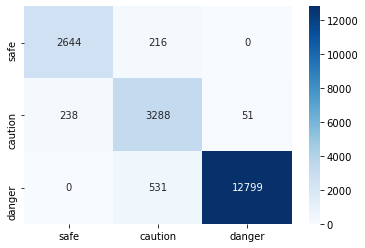

In [14]:
#Confusion Matrix
class_names = np.unique(y_test)
target_names = ['safe', 'caution', 'danger']
confmat = confusion_matrix(y_test, y_test_pred, labels=class_names)
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)
plt.savefig('LR.png', dpi=300, bbox_inches='tight')
plt.show()

# Test

In [15]:
# Importing the dataset
#Downloading the dataset, creating dataframe
df2 = pd.read_excel("Test_Data_Exp2.xlsx")
df2 = df2.drop(['Mean 260 (°C)'], axis=1)

In [16]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df2['labels'] = df2['labels'].map(target_mapping)

# Separating data & target information
X2 = df2.iloc[:, :3]
y2 = df2.iloc [:, -1]

print('Number of safe, caution and danger respectively in target:', np.bincount(y2))

Number of safe, caution and danger respectively in target: [2762 4099 1698]


In [17]:
y_test1_pred = pipe_logreg.predict(X2)

accuracy_score(y2, y_test1_pred)

print(accuracy_score(y2, y_test1_pred))
print(classification_report(y2, y_test1_pred))
print('Misclassified samples: %d' % (y2 != y_test1_pred).sum())

confusion_matrix(y2, y_test1_pred)

0.5393153405771702
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2762
           1       0.95      0.04      0.08      4099
           2       0.33      1.00      0.49      1698

    accuracy                           0.54      8559
   macro avg       0.71      0.68      0.50      8559
weighted avg       0.80      0.54      0.43      8559

Misclassified samples: 3943


array([[2762,    0,    0],
       [ 492,  164, 3443],
       [   0,    8, 1690]])

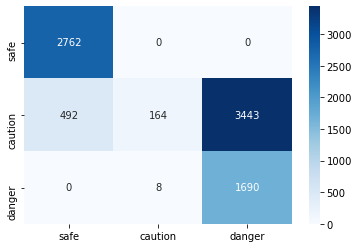

In [18]:
class_names = np.unique(y2)
target_names = ['safe', 'caution', 'danger']
confmat = confusion_matrix(y2, y_test1_pred, labels=class_names)
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)
plt.savefig('plt.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Importing the dataset
#Downloading the dataset, creating dataframe
df3 = pd.read_excel("Exp2_mean.xlsx")
df3 = df3.drop(['Mean 260 (°C)'], axis=1)

In [20]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df3['labels'] = df3['labels'].map(target_mapping)

# Separating data & target information
X3 = df3.iloc[:, :3]
y3 = df3.iloc [:, -1]

print('Number of safe, caution and danger respectively in target:', np.bincount(y3))

Number of safe, caution and danger respectively in target: [2433 4066 9995]


In [21]:
y_test2_pred = pipe_logreg.predict(X3)

accuracy_score(y3, y_test2_pred)

print(accuracy_score(y3, y_test2_pred))
print(classification_report(y3, y_test2_pred))
print('Misclassified samples: %d' % (y3 != y_test2_pred).sum())

confusion_matrix(y3, y_test2_pred)

0.9128167818600703
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      2433
           1       0.77      0.93      0.84      4066
           2       1.00      0.95      0.98      9995

    accuracy                           0.91     16494
   macro avg       0.87      0.87      0.87     16494
weighted avg       0.92      0.91      0.91     16494

Misclassified samples: 1438


array([[1769,  664,    0],
       [ 297, 3769,    0],
       [   0,  477, 9518]])

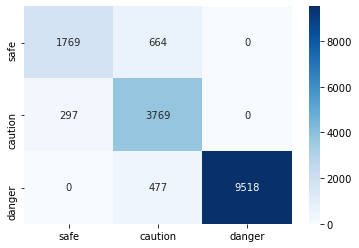

In [22]:
class_names = np.unique(y3)
target_names = ['safe', 'caution', 'danger']
confmat = confusion_matrix(y3, y_test2_pred, labels=class_names)
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)
plt.savefig('plt.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Importing the dataset
#Downloading the dataset, creating dataframe
df4 = pd.read_excel("Data_Gen_Exp1_2.xlsx")
df4 = df4.drop(['260 (°C)'], axis=1)

In [24]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df4['labels'] = df4['labels'].map(target_mapping)

# Separating data & target information
X4 = df4.iloc[:, :3]
y4 = df4.iloc [:, -1]

print('Number of safe, caution and danger respectively in target:', np.bincount(y4))

Number of safe, caution and danger respectively in target: [1328 6539 3892]


In [25]:
y_test3_pred = pipe_logreg.predict(X4)

accuracy_score(y4, y_test3_pred)

print(accuracy_score(y4, y_test3_pred))
print(classification_report(y4, y_test3_pred))
print('Misclassified samples: %d' % (y4 != y_test3_pred).sum())

confusion_matrix(y4, y_test3_pred)

0.9340930351220342
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1328
           1       0.91      0.97      0.94      6539
           2       1.00      0.84      0.92      3892

    accuracy                           0.93     11759
   macro avg       0.93      0.94      0.93     11759
weighted avg       0.94      0.93      0.93     11759

Misclassified samples: 775


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 060 (°C)
Feature names seen at fit time, yet now missing:
- Mean 060 (°C)

  warnings.warn(message, FutureWarning)


array([[1326,    2,    0],
       [ 166, 6372,    1],
       [   0,  606, 3286]])

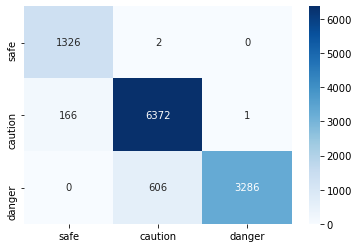

In [26]:
class_names = np.unique(y4)
target_names = ['safe', 'caution', 'danger']
confmat = confusion_matrix(y4, y_test3_pred, labels=class_names)
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)
plt.savefig('plt.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Importing the dataset
#Downloading the dataset, creating dataframe
df5 = pd.read_excel("Data_Gen_Exp3_8.xlsx")
df5 = df5.drop(['260 (°C)'], axis=1)

In [28]:
# Mapping non-numeric columnns (ie target column)
target_mapping = {'danger':2, 'caution':1, 'safe':0}

df5['labels'] = df5['labels'].map(target_mapping)

# Separating data & target information
X5 = df5.iloc[:, :3]
y5 = df5.iloc [:, -1]

print('Number of safe, caution and danger respectively in target:', np.bincount(y5))

Number of safe, caution and danger respectively in target: [ 2718  3756 10020]


In [29]:
y_test4_pred = pipe_logreg.predict(X5)

accuracy_score(y5, y_test4_pred)

print(accuracy_score(y5, y_test4_pred))
print(classification_report(y5, y_test4_pred))
print('Misclassified samples: %d' % (y5 != y_test4_pred).sum())

confusion_matrix(y5, y_test4_pred)

0.9136049472535468
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2718
           1       0.75      0.92      0.83      3756
           2       1.00      0.95      0.97     10020

    accuracy                           0.91     16494
   macro avg       0.88      0.88      0.87     16494
weighted avg       0.92      0.91      0.92     16494

Misclassified samples: 1425


/Users/adenreleishola/opt/anaconda3/envs/tfs/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- 060 (°C)
Feature names seen at fit time, yet now missing:
- Mean 060 (°C)

  warnings.warn(message, FutureWarning)


array([[2091,  627,    0],
       [ 297, 3459,    0],
       [   0,  501, 9519]])

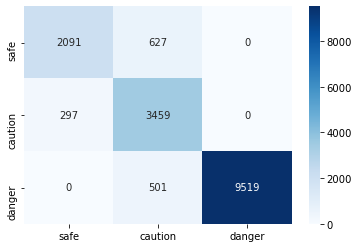

In [30]:
class_names = np.unique(y5)
target_names = ['safe', 'caution', 'danger']
confmat = confusion_matrix(y5, y_test4_pred, labels=class_names)
categories = ['safe', 'caution', 'danger']
sns.heatmap(confmat, annot=True, fmt="d",cmap='Blues', xticklabels= categories, yticklabels=categories)
plt.savefig('plt.png', dpi=300, bbox_inches='tight')
plt.show()